In [1]:
!pip install nltk scikit-learn numpy pandas -q

**Importing the Dependencies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

**Data Loading & Understanding**

In [3]:
# loading the dataset to a pandas dataframe
df = pd.read_csv("movies.csv")

In [4]:
df.shape

(4803, 24)

In [5]:
df.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [7]:
# filter the required columns for recommendation
required_columns = ["genres", "keywords", "overview", "title"]

df = df[required_columns]

In [8]:
df.shape

(4803, 4)

In [9]:
df.head()

,genres,keywords,overview,title
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...",Avatar
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A cryptic message from Bond’s past sends him o...,Spectre
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Following the death of District Attorney Harve...,The Dark Knight Rises
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"John Carter is a war-weary, former military ca...",John Carter


In [10]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genres    4775 non-null   object
 1   keywords  4391 non-null   object
 2   overview  4800 non-null   object
 3   title     4803 non-null   object
dtypes: object(4)
memory usage: 150.2+ KB


In [11]:
df = df.dropna().reset_index(drop=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4387 entries, 0 to 4386
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genres    4387 non-null   object
 1   keywords  4387 non-null   object
 2   overview  4387 non-null   object
 3   title     4387 non-null   object
dtypes: object(4)
memory usage: 137.2+ KB


In [14]:
df['combined'] = df['genres'] + ' ' + df['keywords'] + ' ' + df['overview']

In [15]:
df.head()

,genres,keywords,overview,title,combined
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...",Avatar,Action Adventure Fantasy Science Fiction cultu...
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A cryptic message from Bond’s past sends him o...,Spectre,Action Adventure Crime spy based on novel secr...
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Following the death of District Attorney Harve...,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"John Carter is a war-weary, former military ca...",John Carter,Action Adventure Science Fiction based on nove...


In [16]:
df.tail()

,genres,keywords,overview,title,combined
4382,Drama,gang audition police fake homeless actress,A young woman in L.A. is having a bad day: she...,Bang,Drama gang audition police fake homeless actre...
4383,Science Fiction Drama Thriller,distrust garage identity crisis time travel ti...,Friends/fledgling entrepreneurs invent a devic...,Primer,Science Fiction Drama Thriller distrust garage...
4384,Action Crime Thriller,united states\u2013mexico barrier legs arms pa...,El Mariachi just wants to play his guitar and ...,El Mariachi,Action Crime Thriller united states\u2013mexic...
4385,Comedy Drama Romance TV Movie,date love at first sight narration investigati...,"""Signed, Sealed, Delivered"" introduces a dedic...","Signed, Sealed, Delivered",Comedy Drama Romance TV Movie date love at fir...
4386,Documentary,obsession camcorder crush dream girl,Ever since the second grade when he first saw ...,My Date with Drew,Documentary obsession camcorder crush dream gi...


In [17]:
data = df[['title', 'combined']]

In [18]:
data.head()

,title,combined
0,Avatar,Action Adventure Fantasy Science Fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...


In [19]:
data.shape

(4387, 2)

In [20]:
# WordCloud for movie content
combined_text = " ".join(df['combined'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text)

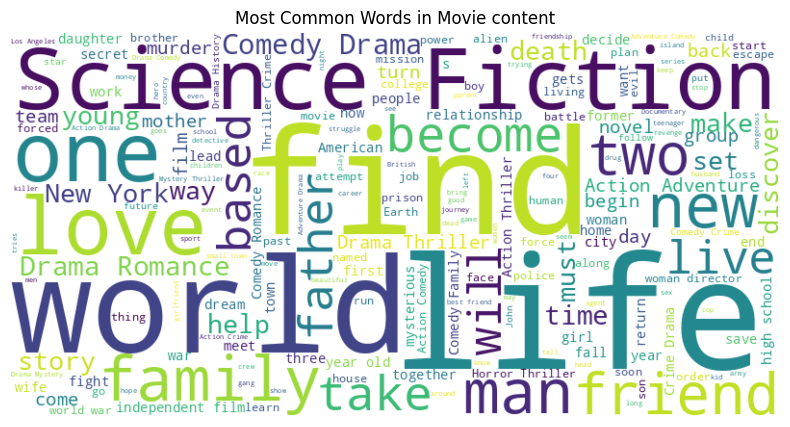

In [21]:
# WordCloud to visualize the most common words in the movie content
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Movie content")
plt.show()

In [22]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stop_words = set(stopwords.words('english'))

In [24]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [25]:
# Apply preprocessing to the movie content
data['cleaned_text'] = df['combined'].apply(preprocess_text)

<ipython-input-25-9024bdc506f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_text'] = df['combined'].apply(preprocess_text)


In [26]:
data.head()

,title,combined,cleaned_text
0,Avatar,Action Adventure Fantasy Science Fiction cultu...,action adventure fantasy science fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...,adventure fantasy action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...,action adventure crime spy based novel secret ...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...,action crime drama thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...,action adventure science fiction based novel m...


In [27]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])

In [28]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [35]:
print(cosine_sim[1])

[0.02901396 1.         0.03100093 ... 0.01749756 0.02801405 0.        ]


In [36]:
# Recommendation Function
def recommend_movies(movie_name, cosine_sim=cosine_sim, df=data, top_n=5):
    # Find the index of the movie
    idx = df[df['title'].str.lower() == movie_name.lower()].index
    if len(idx) == 0:
        return "Movie not found in the dataset!"
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return top n similar movies
    return df[['title']].iloc[movie_indices]

In [37]:
data["title"]

,title
0,Avatar
1,Pirates of the Caribbean: At World's End
2,Spectre
3,The Dark Knight Rises
4,John Carter
...,...
4382,Bang
4383,Primer
4384,El Mariachi
4385,"Signed, Sealed, Delivered"


In [39]:
# row_index = df[df['title'] == "Avengers: Age of Ultron"].index
row_index = df[df['title'] == "Batman v Superman: Dawn of Justice"].index
print(row_index)

Index([9], dtype='int64')


In [42]:
movie_name = data["title"][9]
print(movie_name)

Batman v Superman: Dawn of Justice


In [43]:
# Example Recommendation
print(f"Recommendations for the Movie {movie_name}")
recommendations = recommend_movies(movie_name)
print(recommendations)

Recommendations for the Movie Batman v Superman: Dawn of Justice
                title
14       Man of Steel
861       Superman II
424    Batman Returns
1401  Superhero Movie
3590         Defendor
